In [1]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import yuGANoh_with_fc_and_disc
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import zipfile

## Loading data

We initialize a transform that reshapes the data and transforms the data into a Tensor.

Then, we specify the data directory and initialize the dataloaders.

Lastly, we show an example image from the dataset.

In [2]:
#initialize transform
transform = transforms.Compose([
    transforms.Resize((428,321)),
    transforms.ToTensor()
])

In [3]:
#initialize dataloader
#root_dir = 'YOUR DATA HERE'
root_dir = 'C:/Users/micha/Desktop/old_files/card'
batch_size = 45
ygoDset = yuGANoh_with_fc_and_disc.YgoCards(root_dir=root_dir,transform = transform)
ygoLoader = DataLoader(ygoDset, batch_size=batch_size, shuffle=True, num_workers=4)

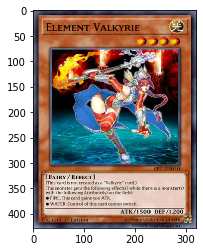

In [4]:
#preview data
batch = next(iter(ygoLoader))
trans = transforms.ToPILImage()
plt.imshow(trans(batch[0]))

## Hyperparameters

Here we will introduce the network hyperparameters:

- latent_size:  Length of the noise vector as network input.
- num_gan_features:  Controls width of the generator network. Higher value leads to wider network.
- num_disc_fatures:  Controls width of the discriminator network. Higher value leads to wider network.
- num_hidden_features:  Length of hidden features learned by discriminator. This is the input to the fully connected layers.
- lr:  Network learning rate.
- beta1:  Adam parameter, controls gradient derivative for momentum calc. See torch.nn.
- num_epochs:  Number of training epochs
- similarity_features:  Number of features to learn for minibatch discrimination.
- lower_bound:  Lower bound for label smoothing.
- bound: Size of bound for label smoothing.

In [5]:
#network params
latent_size = 50
num_gan_features = 56
num_disc_features = num_gan_features
num_hidden_features = 256
lr = .0001
beta1 = 0.5
num_epochs = 100
similarity_features = 50
lower_bound = 0.8
bound = 1- lower_bound

In [6]:
#initialize network
device = torch.device('cuda:0')
gen = yuGANoh_with_fc_and_disc.Generator(latent_size,num_gan_features).to(device)
disc = yuGANoh_with_fc_and_disc.Discriminator(num_disc_features,num_hidden_features,similarity_features).to(device)
gen.apply(yuGANoh_with_fc_and_disc.init_weights)
print(gen)
disc.apply(yuGANoh_with_fc_and_disc.init_weights)
print(disc)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 448, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(448, 224, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2), bias=False)
    (4): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(224, 112, kernel_size=(5, 5), stride=(3, 3), padding=(3, 2), bias=False)
    (7): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(112, 112, kernel_size=(5, 5), stride=(3, 3), padding=(3, 2), bias=False)
    (10): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTran

C:\Users\micha\Desktop\GitHub\Yu-GAN-Oh\yuGANoh_with_fc_and_disc.py:205: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight.data)


In [7]:
#initialize loss and optimizer
criterion = nn.BCELoss()
noise = torch.randn(1,latent_size,1,1).to(device)
optimizerD = optim.Adam(disc.parameters(),lr=lr,betas=(beta1,0.999), weight_decay = .0001)
optimizerG = optim.Adam(gen.parameters(),lr=2*lr,betas=(beta1,0.999), weight_decay = .0001)

## Feature Loss

Feature loss is a better loss function to use for the generator training step. We aim to generate data that the discriminator thinks is similar, but instead of having a similar label, we aim to have the features extracted by the discriminator to be similar.

In [8]:
def feature_loss(real_features,fake_features):
    temp = torch.mean(real_features,axis=0) - torch.mean(fake_features,axis=0)
    return torch.sum(temp*temp)

## Debug functions

Most of these are here for debugging. check_norm is kept in the training loop.

In [9]:
def check_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is None:
            continue
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    print(total_norm)
    
def normalize_tensors(inp):
    return (inp-0.5)*2

def undo_normalize(inp):
    return inp/2 + 0.5

def check_individual_norm(model):
    for p in model.parameters():
        if p.grad is None:
            print(str(p.name)+' is None')
            continue
        print(str(p.name) +': '+  str(p.grad.data.norm(2).item()**2))

## Training Loop

Training loop with 4 parts.

- Real image data:  Run real data through discriminator. Backprop.
- Fake image data:  Run noise through generator and then put output into discriminator. Backprop.
- Update Discriminator:  Step through the discriminator optimizer.
- Update Generator:  Run same noise through generator (thus, same output) and then input into discriminator. Then, backprop and step through Generator optimizer.



In [10]:
#disc.load_state_dict(torch.load('disc22.pt'))
#gen.load_state_dict(torch.load('gen22.pt'))

In [ ]:
images = []
gen_losses = []
disc_losses = []


print("Begin training")
for epoch in range(num_epochs):
    for i,img in enumerate(ygoLoader,0):
        #zero discriminator gradient
        disc.zero_grad()
        
        
        #run real image through discriminator
        img = img.to(device)
        #img = normalize_tensors(img) + 0.1*torch.randn_like(img).to(device)
        if epoch < 15:
            img = img + 0.1*torch.randn_like(img).to(device)
        b_size = img.shape[0]
        features_real, output = disc(img)
        output = output.squeeze()
        #real_label = 1
        #label = torch.ones_like(output).to(device)
        label = 1 - bound*torch.rand_like(output)
        disc_loss_real = criterion(output,label)
        disc_loss_real.backward()
        
        
        #now run a fake batch through generator.
        inp = torch.randn(b_size,latent_size,1,1).to(device)
        gen_out = gen(inp)
        features_fake, fake_out = disc(gen_out)
        fake_out = fake_out.squeeze()
        #fake_label = 0
        label_fake = label*0
        disc_loss_fake = criterion(fake_out,label_fake)
        disc_loss_fake.backward()
        total_loss = disc_loss_real + disc_loss_fake       
        optimizerD.step()
        
        # train the generator
        # we already have a generator pass with gen_out=gen(inp)
        gen.zero_grad()
        disc.zero_grad()
        gen_out = gen(inp)
        features_real, real_out = disc(img)
        features_fake, fake_out = disc(gen_out)
        model_loss = feature_loss(features_real,features_fake)
        model_loss.backward()
        optimizerG.step()
        '''
        #train the generator again
        #we already have a generator pass with gen_out=gen(inp)
        gen.zero_grad()
        features_out_real , model_out = disc(gen_out)
        model_out = model_out.squeeze()
        model_loss = feature_loss(features_out_real,features_fake)
        model_loss.backward()   
        optimizerG.step()'''
        
        #check_individual_norm(gen)
        #check_individual_norm(disc)
        
        if i%50 == 0:
            disc_losses.append(total_loss.item())
            gen_losses.append(model_loss.item())
            print('Epoch: '+str(epoch) + ' iter: ' + str(i) + ' lossG: ' + str(gen_losses[-1]) + ' lossD: ' + str(disc_losses[-1]))
            out_img = gen(noise)
            #out_img = undo_normalize(out_img)
            trans = transforms.ToPILImage()
            plt.imshow(trans(out_img[0].cpu()))
            plt.show()
            if gen_losses[-1] == 0.0:
                break
            if disc_losses[-1] == 0.0:
                break
            print('discriminator gradient L2 Norm')
            check_norm(disc)
            print('generator gradient L2 Norm')
            check_norm(gen)

## After training

The next few cells are for visualizing loss and an example output image. There is also code to save the model.

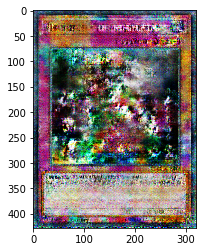

In [18]:
noise = torch.randn(1,latent_size,1,1).to(device)
out_img = gen(noise)
#out_img = undo_normalize(out_img)
trans = transforms.ToPILImage()
plt.imshow(trans(out_img[0].cpu()))

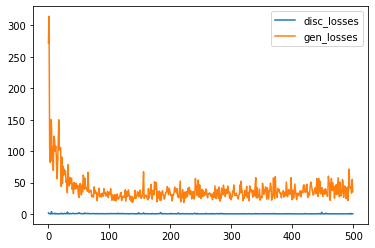

In [13]:
plt.plot(disc_losses)
plt.plot(gen_losses)
plt.legend(['disc_losses','gen_losses'])
plt.show()

In [14]:
torch.save(gen.state_dict(), 'gen24.pt')
torch.save(disc.state_dict(), 'disc24.pt')

In [15]:
torch.save(disc_losses,'disc22_loss_weight-dec_2.pt')

In [16]:
torch.save(gen_losses,'gen22_loss_weight-dec_2.pt')

torch.Size([16, 3, 428, 321])


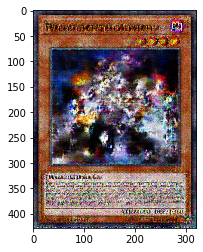

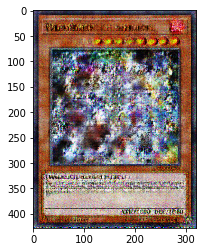

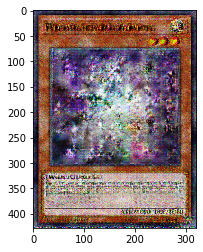

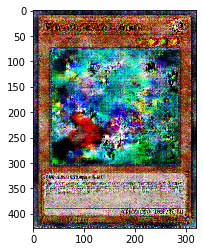

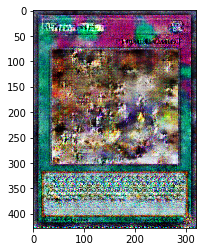

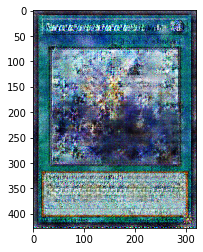

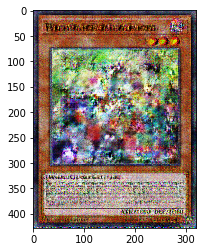

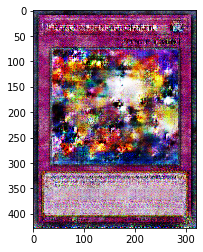

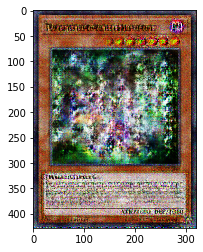

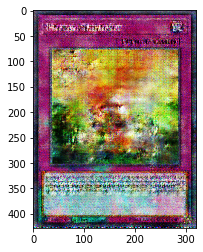

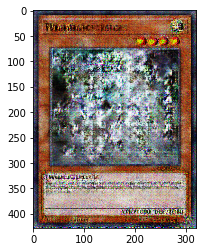

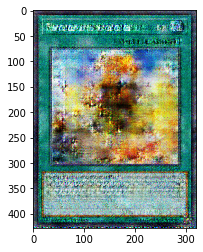

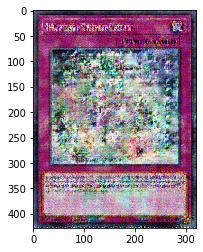

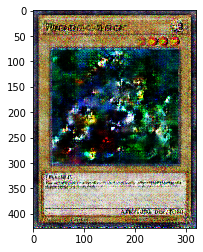

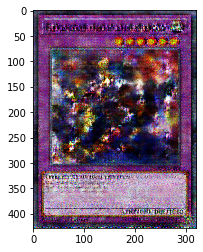

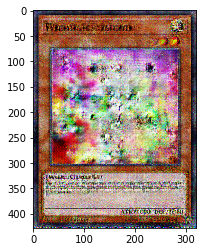

In [22]:
noise_2 = torch.randn(16,latent_size,1,1).to(device)
out_imgs = gen(noise_2)
print(out_imgs.shape)
#out_img = undo_normalize(out_img)
trans = transforms.ToPILImage()
for i in range(noise_2.shape[0]):
    plt.imshow(trans(out_imgs[i].cpu()))
    plt.show()